##Proyek Akhir Klasifikasi Gambar##
- Nama: Fairuz Aqila Anindika
- Email: fairuzaqilaanindika02@gmail.com
- ID Dicoding: anindika


#Import Library

In [2]:
import os
import zipfile
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Specify the path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/Dataset/satellite.zip'

# Specify the directory to extract to
extract_to = '/content/drive/MyDrive/Dataset'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed.")


Extraction completed.


##Melihat jumlah citra dan ukuran resolusi

In [4]:
from PIL import Image
from collections import defaultdict

dataset_dir = '/content/drive/MyDrive/Dataset/satellite'

# Dictionary to store resolutions and corresponding image paths
resolution_dict = defaultdict(list)

# Iterate through each subfolder (category)
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)

    # Check if it's a directory
    if os.path.isdir(category_path):
        # Iterate through each image in the category folder
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)

            # Open the image and get its resolution
            with Image.open(image_path) as img:
                resolution = img.size  # (width, height)
                resolution_dict[resolution].append(image_path)

# Check for resolutions with more than one image
print("=== Resolutions Summary ===")
duplicate_count = 0
for resolution, images in resolution_dict.items():
    if len(images) > 1:
        print(f"Resolution {resolution} is shared by {len(images)} images")
        duplicate_count += len(images)

if duplicate_count > 0:
    print(f"Total number of images with duplicated resolutions: {duplicate_count}")
else:
    print("All images have unique resolutions.")

=== Resolutions Summary ===
Resolution (256, 256) is shared by 6438 images
Resolution (64, 64) is shared by 2941 images
Total number of images with duplicated resolutions: 9379


##Data Augmentation

In [5]:
# Create an instance of ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)  # 20% of the data will be used as validation data

# Create an instance of ImageDataGenerator for validation data (without augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Generate batches of augmented data for training
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Use the training subset
    seed=1000)

# Generate batches of data for validation (without augmentation)
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Use the validation subset
    seed=1000)

Found 7505 images belonging to 4 classes.
Found 1874 images belonging to 4 classes.


##Label

In [7]:
# Labels with their class names
class_labels = {class_name: i for i, class_name in enumerate(train_generator.class_indices)}
print(class_labels)

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


#Modelling

In [8]:
# Define the model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax')) # 4 classes

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 63, 63, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,711,268 (14.16 MB)

 Trainable params: 3,711,268 (14.16 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# Define class for early stopping
class EarlyStopping(keras.callbacks.Callback):
    def __init__(self,
                 threshold,
                 patience=2,
                 restore_best_weights='True'):
        super(EarlyStopping, self).__init__()
        self.threshold = threshold

    # Applying early callback
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [12]:
# Training will stop when validation acc reaches 0.97
mycallback = EarlyStopping(threshold=0.96)
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    verbose=2,
                    callbacks=[mycallback])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 - 91s - 389ms/step - accuracy: 0.9067 - loss: 0.2471 - val_accuracy: 0.9466 - val_loss: 0.1635
Epoch 2/20
235/235 - 40s - 169ms/step - accuracy: 0.9328 - loss: 0.1863 - val_accuracy: 0.9530 - val_loss: 0.1356
Epoch 3/20
235/235 - 37s - 157ms/step - accuracy: 0.9399 - loss: 0.1617 - val_accuracy: 0.9546 - val_loss: 0.1372
Epoch 4/20
235/235 - 36s - 155ms/step - accuracy: 0.9444 - loss: 0.1500 - val_accuracy: 0.9594 - val_loss: 0.1244
Epoch 5/20
235/235 - 40s - 170ms/step - accuracy: 0.9572 - loss: 0.1297 - val_accuracy: 0.9312 - val_loss: 0.1717
Epoch 6/20
235/235 - 40s - 168ms/step - accuracy: 0.9584 - loss: 0.1236 - val_accuracy: 0.9616 - val_loss: 0.1056


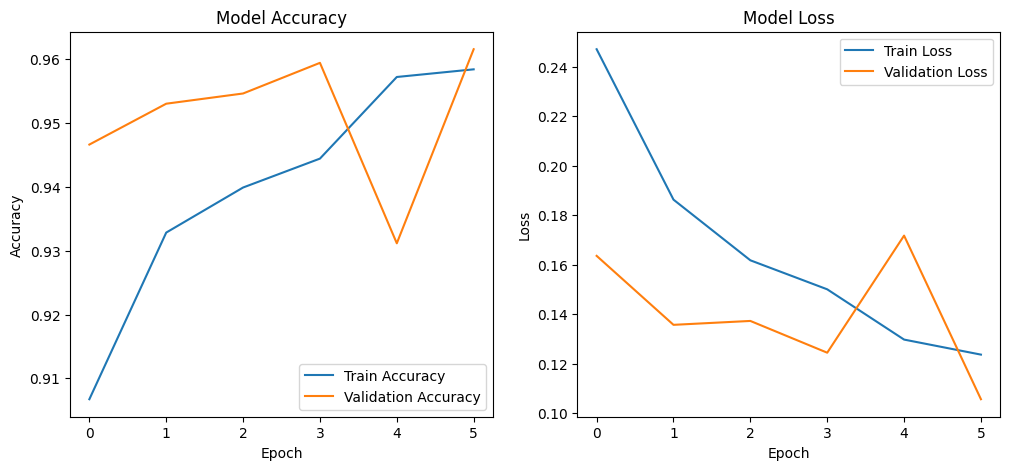

In [13]:
# Plotting accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plots
plt.show()

#Save Model

In [14]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [15]:
model.save("h5_model.h5")

In [16]:
keras_model = tf.keras.models.load_model("/content/h5_model.h5")

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)


In [18]:
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp9h410cx7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138171247802880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138171247796544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138171248087936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138171248085296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138171247382544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138171247384832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138171247390112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138171247393632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138171247393808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138170206274304: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [19]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


#Menyimpan Model dalam Format TensorFlow.js (TFJS)

In [20]:
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [21]:
import tensorflowjs as tfjs

# Menyimpan model ke format TFJS

!tensorflowjs_converter --input_format=tf_saved_model 'saved_model/' 'tfjs_model/'


2024-09-10 06:07:26.973029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 06:07:27.014562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 06:07:27.025769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 06:07:28.167845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1725948449.985931    8934 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

In [22]:
 pip freeze requirements.txt


absl-py==1.4.0
accelerate==0.33.0
aiohappyeyeballs==2.4.0
aiohttp==3.10.5
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.14
albumentations==1.4.14
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.18.0
asn1crypto==1.5.1
astropy==6.1.3
astropy-iers-data==0.2024.8.27.10.28.29
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.15.0
bigquery-magics==0.2.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
clarabel==0.9.0
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.19.0
cloudpickle==2.2.1
cmake==3.30.2
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5